In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from os.path import join, basename, dirname
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted
from tqdm import tqdm
import torch

from torchvision.io import read_image
from torchvision.utils import make_grid
from torchvision import transforms

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

In [3]:
from experiment_utils import set_env, REPO_PATH, seed_everything
set_env()

In [4]:
from experiments.image_utils import denormalize, show_single_image

In [5]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Set environment

In [6]:
seed_everything(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load `ImageNet` dataset

In [7]:
from imagenet.dataloader import get_imagenet_dls

In [8]:
train_loader, val_loader, train_sampler = get_imagenet_dls(
    "imagenet/data/in-mini", False, 32, 4,
)

In [9]:
len(train_loader), len(val_loader)

(1086, 123)

In [10]:
ds_val = val_loader.dataset

In [11]:
# check out a sample
index = 0
sample = ds_val[index]

In [12]:
sample["ims"].shape, sample["ims"].min(), sample["ims"].max(), sample["labels"]

(torch.Size([3, 224, 224]), tensor(-2.0837), tensor(2.6400), tensor(0))

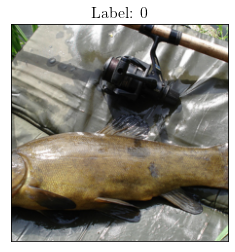

In [13]:
show_single_image(sample["ims"], title=f"Label: {sample['labels'].data}")

### Load model

In [14]:
from imagenet.models.classifier_ensemble import InvariantEnsemble

In [15]:
model = InvariantEnsemble("resnet50", pretrained=True)

In [16]:
# load weights from a checkpoint
ckpt_path = "imagenet/experiments/classifier_2022_01_19_15_36_sample_run/model_best.pth"
ckpt = torch.load(ckpt_path, map_location="cpu")
ckpt_state_dict = ckpt["state_dict"]
ckpt_state_dict = {k.replace("module.", ""):v for k, v in ckpt_state_dict.items()}

In [17]:
model.load_state_dict(ckpt_state_dict)

<All keys matched successfully>

In [18]:
model = model.eval()

In [19]:
model = model.to(device)

### Run forward pass and store predictions

In [20]:
iterator = tqdm(
    enumerate(val_loader),
    desc="Evaluating on validation set",
    bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}',
)

y_shape_all = []
y_texture_all = []
y_bg_all = []

with torch.no_grad():
    for i, batch in iterator:
        
        if i == 10 + 1:
            break

        ims = batch["ims"].to(device)
        labels = batch["labels"].to(device)

        out = model(ims)

        y_shape = out["shape_preds"][np.arange(0, len(labels), 1), labels]
        y_texture = out["texture_preds"][np.arange(0, len(labels), 1), labels]
        y_bg = out["bg_preds"][np.arange(0, len(labels), 1), labels]
        
        y_shape_all.append(y_shape.data.cpu())
        y_texture_all.append(y_texture.data.cpu())
        y_bg_all.append(y_bg.data.cpu())

Evaluating on validation set: |          | 11/? [01:33<00:00,  8.46s/it]                                                   


### Plot contributions

In [21]:
y_shape_all = torch.cat(y_shape_all)
y_texture_all = torch.cat(y_texture_all)
y_bg_all = torch.cat(y_bg_all)

In [22]:
y_shape_all.shape

torch.Size([352])

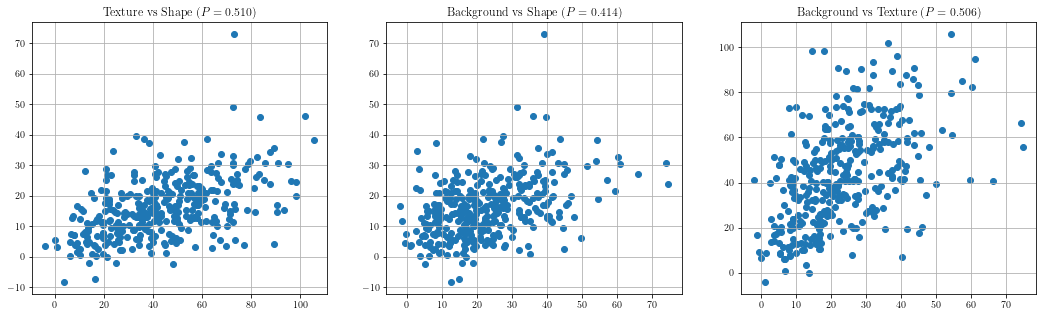

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].scatter(y_texture_all, y_shape_all)
corr = np.corrcoef(y_texture_all, y_shape_all)[0, 1]
ax[0].set_title(f"Texture vs Shape ($P = {corr:.3f}$)")
ax[0].grid()

ax[1].scatter(y_bg_all, y_shape_all)
corr = np.corrcoef(y_bg_all, y_shape_all)[0, 1]
ax[1].set_title(f"Background vs Shape ($P = {corr:.3f}$)")
ax[1].grid()

ax[2].scatter(y_bg_all, y_texture_all)
corr = np.corrcoef(y_bg_all, y_texture_all)[0, 1]
ax[2].set_title(f"Background vs Texture ($P = {corr:.3f}$)")
ax[2].grid()

plt.show()

1. For invariance, the whole point was that these mechanisms are de-correlated. We expect the shape branch to not rely on background and so on. 
2. Hypothesis: If we train on CF data, then we *should* get a relatively very low correlation among these.
3. Hypothesis: If we solely train on original data, then we *should* get a relatively  very high correlation among these.

### Plot contributions on CF data

In [25]:
# Read the ImageNet categories
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
with open("imagenet_classes.txt", "r") as f:
    imagenet_categories = [s.strip() for s in f.readlines()]

--2022-01-23 12:07:40--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.2’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0.003s  

2022-01-23 12:07:40 (3.69 MB/s) - ‘imagenet_classes.txt.2’ saved [10472/10472]



In [26]:
from cgn_framework.imagenet.models import CGN
from cgn_framework.imagenet.generate_data import sample_classes

cgn = CGN(batch_sz=1, pretrained=False)

# load weights and push to GPU
weights = torch.load(join(REPO_PATH, 'cgn_framework/imagenet/weights/cgn.pth'), map_location='cpu')
cgn.load_state_dict(weights)
cgn.eval().to(device);

In [ ]:
# Get the input classes

num_samples = 60
ys_all = []

y_shape_all = []
y_texture_all = []
y_bg_all = []

for i in tqdm(range(num_samples), desc="Evaluating on CF examples"):
    ys = sample_classes('best_classes')
    labels = [ys[0]]

    # Generate the output
    with torch.no_grad():
        # get generated image (in [-1, 1])
        x_gt, mask, premask, foreground, background, bg_mask = cgn(ys=ys)
        x_gen = mask * foreground + (1 - mask) * background
        
        # forward pass the generated image
        image = x_gen[0]
        pil_image = transforms.ToPILImage()((image + 1) * 0.5)
        transformed_image = ds_val.T_ims(pil_image)
        
        # get classifier outputs
        out = model(transformed_image.unsqueeze(0))

        y_shape = out["shape_preds"][np.arange(0, len(labels), 1), labels]
        y_texture = out["texture_preds"][np.arange(0, len(labels), 1), labels]
        y_bg = out["bg_preds"][np.arange(0, len(labels), 1), labels]

        y_shape_all.append(y_shape.data.cpu())
        y_texture_all.append(y_texture.data.cpu())
        y_bg_all.append(y_bg.data.cpu())

y_shape_all = torch.cat(y_shape_all)
y_texture_all = torch.cat(y_texture_all)
y_bg_all = torch.cat(y_bg_all)

Evaluating on CF examples:  75%|████████████████████████████████████████████▎              | 45/60 [09:33<03:32, 14.14s/it]

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].scatter(y_texture_all, y_shape_all)
corr = np.corrcoef(y_texture_all, y_shape_all)[0, 1]
ax[0].set_title(f"Texture vs Shape ($P = {corr:.3f}$)")
ax[0].grid()

ax[1].scatter(y_bg_all, y_shape_all)
corr = np.corrcoef(y_bg_all, y_shape_all)[0, 1]
ax[1].set_title(f"Background vs Shape ($P = {corr:.3f}$)")
ax[1].grid()

ax[2].scatter(y_bg_all, y_texture_all)
corr = np.corrcoef(y_bg_all, y_texture_all)[0, 1]
ax[2].set_title(f"Background vs Texture ($P = {corr:.3f}$)")
ax[2].grid()

plt.show()